# ARTisan

Useful resources
- [A Neural Algorithm of Artistic Style (2015)](https://arxiv.org/pdf/1508.06576.pdf)
- [Neural Style Transfer with tf.keras](https://aihub.cloud.google.com/u/0/p/products%2F7f7495dd-6f66-4f8a-8c30-15f211ad6957)
- [Salvador AI (Old course project)](https://dellacqua.se/education/courses/tnm095/archive/2017/p10.pdf)
- [Style transfer keras example](https://keras.io/examples/generative/neural_style_transfer/)
- [Demystifying Neural Style Transfer](https://arxiv.org/pdf/1701.01036.pdf)

## Test if GPU is available


In [33]:
import tensorflow as tf
print(tf.test.gpu_device_name())

## Setup and getting the images

Tensorflow version: 2.6.0


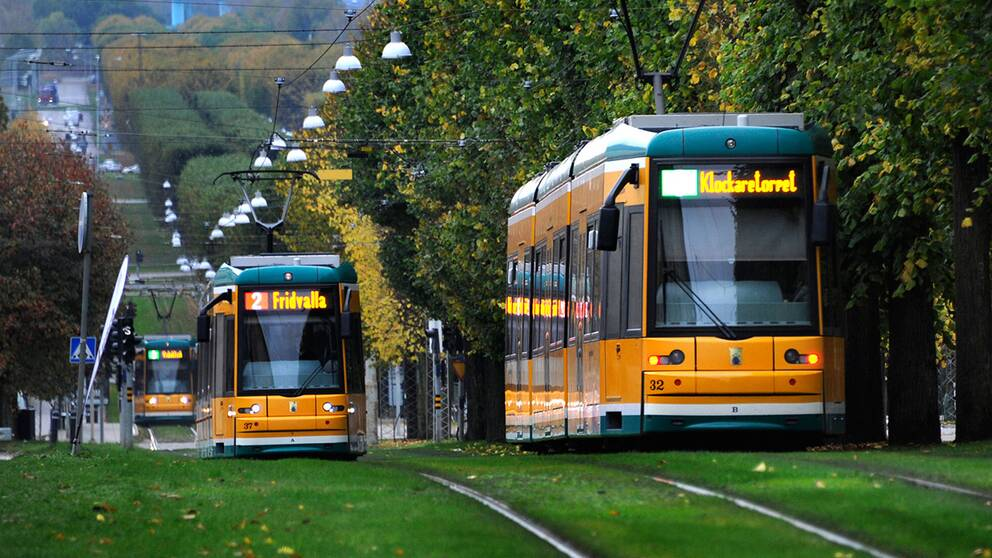

In [34]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import vgg19
from tensorflow import keras
from IPython.display import Image, display

print('Tensorflow version:', tf.__version__)

content_img_path = keras.utils.get_file(
    "trams.jpg", "https://www.svtstatic.se/image/wide/992/15663340/1575374592?format=auto")

# content_img_path = keras.utils.get_file(
#     "rabbel.jpg", "https://static.wikia.nocookie.net/vintergatan/images/f/fd/Rabbel.jpg/revision/latest/scale-to-width-down/1000?cb=20201127071427&path-prefix=sv")
    
style_img_path = keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")

display(Image(content_img_path))
#display(Image(style_img_path))

content_width, content_height = keras.preprocessing.image.load_img(content_img_path).size
n_rows = 400
n_cols = int(content_width * n_rows / content_height)

## Utilities for preprocessing/deprocessing
The VGG19 network expects the data to be in a certain format. More specifically, it expects
- the input to be in BGR rather than RGB
- the input to be zero-centered with respect to the mean of the ImageNet dataset

In [35]:
def preprocess_img(img_path):
  img = keras.preprocessing.image.load_img(
      img_path, target_size=(n_rows, n_cols))
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)

def deprocess_img(x):
  x = x.reshape((n_rows, n_cols, 3))
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # BGR -> RGB
  x = np.clip(x, 0, 255).astype("uint8")
  return x

## Utilities for loss calculations


In [36]:
def content_loss(content, combination):
  return tf.reduce_sum(tf.square(combination - content))

def total_variation_loss(x):
  a = tf.square(
      x[:, : n_rows - 1, : n_cols - 1, :] - x[:, 1:, : n_cols - 1, :]
  )
  b = tf.square(
      x[:, : n_rows - 1, : n_cols - 1, :] - x[:, : n_rows - 1, 1:, :]
  )
  return tf.reduce_sum(tf.pow(a + b, 1.25))

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = n_rows * n_cols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

## Prepare model etc.

In [37]:
model = vgg19.VGG19(weights="imagenet", include_top=False) # Using pretrained weights from imagenet
outputs = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs)

In [38]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-5
content_layer_name = "block5_conv2"
style_layers_names = [
  'block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1']

def compute_loss(combination_img, content_img, style_img):
  # Concatenate tensors along dimension 0
  input_tensor = tf.concat([content_img, style_img, combination_img], axis=0)
  features = feature_extractor(input_tensor)

  loss = tf.zeros(shape=()) # WHY shape=()

  # Style loss
  for layer_name in style_layers_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layers_names)) * sl

  # Total variation loss
  loss += total_variation_weight * total_variation_loss(combination_img)

  # Content loss
  layer_features = features[content_layer_name]
  content_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]
  loss = loss + content_weight * content_loss(content_features, combination_features)

  return loss

## Compute gradient and loss util
Created as a tensorflow function to improve performance, as described [here](https://www.tensorflow.org/guide/function)

In [39]:
@tf.function
def compute_loss_and_gradients(combination_img, content_img, style_img):
  with tf.GradientTape() as tape:
    loss = compute_loss(combination_img, content_img, style_img)
  gradients = tape.gradient(loss, combination_img)
  return loss, gradients

## The optimization loop

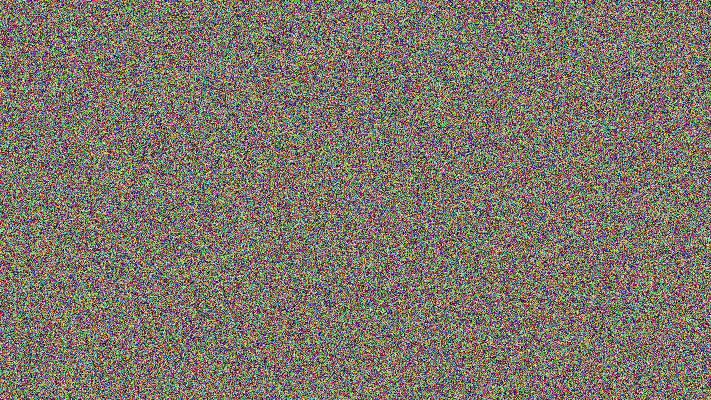

Iteration 100, loss = 51126.5625


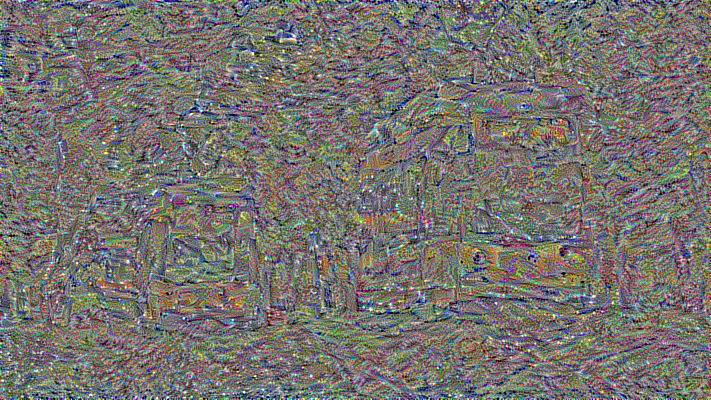

In [40]:
num_iterations = 4000
save_interval = 100

learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 100.0,
    decay_steps = 100,
    decay_rate = 1.00 # 0.96
)
optimizer = keras.optimizers.SGD(learning_rate_schedule)

content_img = preprocess_img(content_img_path)
style_img = preprocess_img(style_img_path)
#combination_img = tf.Variable(preprocess_img(content_img_path))
combination_img = tf.Variable(tf.random.uniform(
    content_img.shape, minval = -128, maxval = 128 # No idea what im doing
))
keras.preprocessing.image.save_img("start.png", deprocess_img(combination_img.numpy()))
display(Image("start.png"))


for i in range(1, num_iterations + 1):
  loss, gradients = compute_loss_and_gradients(combination_img, content_img, style_img)

  optimizer.apply_gradients([(gradients, combination_img)])

  if i % save_interval == 0 or i == num_iterations:
    print(f"Iteration {i}, loss = {loss}")
    img = deprocess_img(combination_img.numpy())
    file_name = f"result-at-{i}-iterations.png"
    keras.preprocessing.image.save_img(file_name, img)
    display(Image(f"result-at-{i}-iterations.png"))